For each TF, convert DNA sequences into a one-hot encoding format. Implement a logistic
regression model with L1 regularization. Employ 10-fold cross-validation to train and validate
your model, making sure that your data is shuffled and stratified across the folds to preserve the
proportion of bound and unbound sequences. [2pt]

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
def parse_fasta(file_path, label):
    sequences = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith('>'):
                sequences.append((line.strip()))
    return pd.DataFrame({'sequence': sequences, 'label': label})

ctcf_bound = parse_fasta('ctcf_bound.fasta', 1)
ctcf_unbound = parse_fasta('ctcf_unbound.fasta', 0)
max_bound = parse_fasta('max_bound.fasta', 1)
max_unbound = parse_fasta('max_unbound.fasta', 0)

ctcf_df = pd.concat([ctcf_bound, ctcf_unbound], ignore_index=True)
max_df = pd.concat([max_bound, max_unbound], ignore_index=True)

In [3]:
def one_hot_encode(seq):
    temp = list(seq.replace('A', '1000').replace('C', '0100').replace('G', '0010').replace('T','0001'))
    return np.array([int(x) for x in temp])

ctcf_df['encoded'] = ctcf_df['sequence'].apply(one_hot_encode)
max_df['encoded'] = max_df['sequence'].apply(one_hot_encode)

For each TF, calculate the AUROC for each fold and report both the average AUROC and its
standard deviation across all folds. Discuss the overall performance of your model based on
these metrics. Additionally, plot the ROC curve for your model, indicating the mean ROC curve
derived from all folds and highlighting the standard deviation to illustrate the variation around
the mean. [3pt]

Hint: Consider using plt.fill_between() to plot the standard deviation around the mean curve.

**Overall, it appears that both of our logistic regression models for CTCF and MAX TF's turned out to be successful, as our CTCF model returned an average AUROC of 0.95 with a standard deviation of 0.007 while our MAX model returned a mean AUROC of 0.93 with SD of 0.003. Given that the lowest possible AUROC is 0.5 when using a random classifier and the maximum is 1, an AUROC value above 0.9 is generally considered to be a robust model because it can achieve a high true positive rate even at relatively low false positive rate thresholds. The fact that both models designed for different TFs performed strongly means that our training pipeline can be generalized across different TFs without necessarily overfitting.**

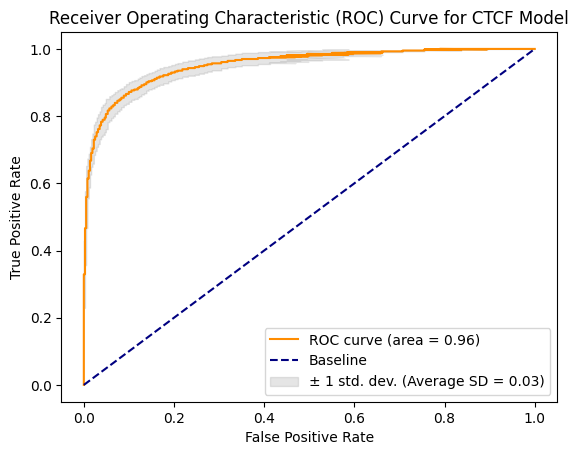

Mean AUROC: 0.9557708506461104; Std. Dev. AUROC: 0.007816159453855102


In [4]:
ctcf_cv = StratifiedKFold(n_splits=10, shuffle=True)
ctcf_X = np.array([x.flatten() for x in ctcf_df['encoded'].tolist()])
ctcf_y = ctcf_df['label'].values
auroc_values = []; tpr_values = [[] for i in range(1000)]; fpr_values = [[] for i in range(1000)]; ctcf_coef_values = [[] for i in range(120)]
for train_index, valid_index in ctcf_cv.split(ctcf_X, ctcf_y):
    X_train, X_test, y_train, y_test = train_test_split(ctcf_X, ctcf_y, test_size=0.2)
    # Fit the model
    log_reg = LogisticRegression(max_iter=100, penalty='l1', solver='liblinear')
    log_reg.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUROC on the test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)
    auroc_values.append(auroc)
    for idx, value in enumerate(tpr):
        tpr_values[idx].append(value)
    for idx, value in enumerate(fpr):
        fpr_values[idx].append(value)
    for idx, value in enumerate(log_reg.coef_[0]):
        ctcf_coef_values[idx].append(value)
        
std_tpr = np.array([np.std(values) for values in tpr_values if values]) 
std_fpr = np.array([np.std(values) for values in fpr_values if values])
mean_tpr = np.array([np.mean(values) for values in tpr_values if values]) 
mean_fpr = np.array([np.mean(values) for values in fpr_values if values])
mean_auroc = np.mean(auroc_values)
std_auroc = np.std(auroc_values)

# Plot AUROC curve
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (area = {mean_auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Baseline')
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=f'± 1 std. dev. (Average SD = {np.mean(std_tpr):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for CTCF Model')
plt.legend(loc="lower right")
plt.show()

print(f'Mean AUROC: {mean_auroc}; Std. Dev. AUROC: {std_auroc}') 

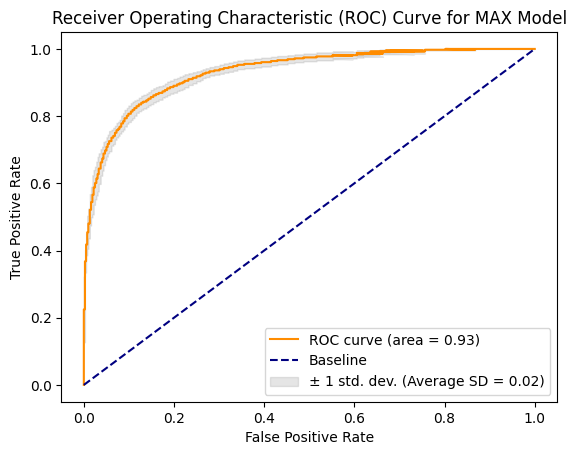

Mean AUROC: 0.9326202701093497; Std. Dev. AUROC: 0.003781652964449859


In [5]:
max_cv = StratifiedKFold(n_splits=10, shuffle=True)
max_X = np.array([x.flatten() for x in max_df['encoded'].tolist()])
max_y = max_df['label'].values
auroc_values = []; tpr_values = [[] for i in range(1000)]; fpr_values = [[] for i in range(1000)]; max_coef_values = [[] for i in range(120)]
for train_index, valid_index in max_cv.split(max_X, max_y):
    X_train, X_test, y_train, y_test = train_test_split(max_X, max_y, test_size=0.2)
    # Fit the model
    log_reg = LogisticRegression(max_iter=100, penalty='l1', solver='liblinear')
    log_reg.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUROC on the test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)
    auroc_values.append(auroc)
    for idx, value in enumerate(tpr):
        tpr_values[idx].append(value)
    for idx, value in enumerate(fpr):
        fpr_values[idx].append(value)
    for idx, value in enumerate(log_reg.coef_[0]):
        max_coef_values[idx].append(value)

std_tpr = np.array([np.std(values) for values in tpr_values if values]) 
std_fpr = np.array([np.std(values) for values in fpr_values if values])
mean_tpr = np.array([np.mean(values) for values in tpr_values if values]) 
mean_fpr = np.array([np.mean(values) for values in fpr_values if values])
mean_auroc = np.mean(auroc_values)
std_auroc = np.std(auroc_values)

# Plot AUROC curve
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=f'ROC curve (area = {mean_auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Baseline')
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=f'± 1 std. dev. (Average SD = {np.mean(std_tpr):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for MAX Model')
plt.legend(loc="lower right")
plt.show()

print(f'Mean AUROC: {mean_auroc}; Std. Dev. AUROC: {std_auroc}') 

For each TF, analyze the logistic regression model to determine which positions in the DNA
sequence are most influential in predicting binding. This involves examining the model's
coefficients for insights into feature importance. Produce a plot for each TF illustrating the
contribution of each base pair position within the model. [2pt]

Hint: Use model.coef_ to obtain the coefficients from your model. Given that each sequence
covers 30 base pairs (bp), compute the mean of the coefficients for the four nucleotides (A, C, G,
T) at every position. In your plot, assign the sequence location to the x-axis and the average
coefficients to the y-axis.

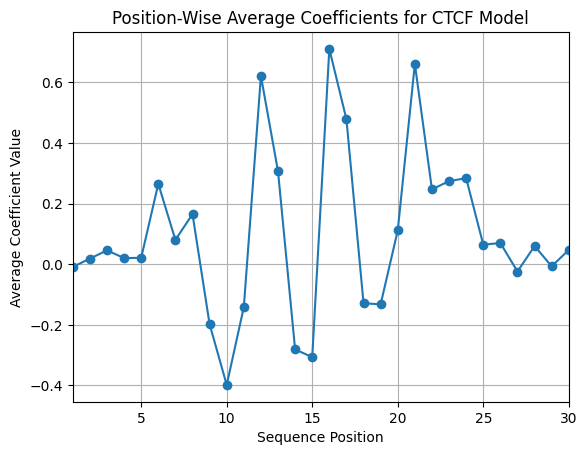

In [6]:
ctcf_mean_coef = np.array([np.mean(values) for values in ctcf_coef_values if values])
ctcf_condensed_coefs = []
for i in range(0, len(ctcf_mean_coef), 4):
    ctcf_condensed_coefs.append(np.mean(ctcf_mean_coef[i:i+4]))

plt.plot(range(1, len(ctcf_condensed_coefs)+1), ctcf_condensed_coefs, marker='o')
plt.xlabel('Sequence Position')
plt.ylabel('Average Coefficient Value')
plt.title('Position-Wise Average Coefficients for CTCF Model')
plt.grid(True)
plt.xlim(1, 30)
plt.show()

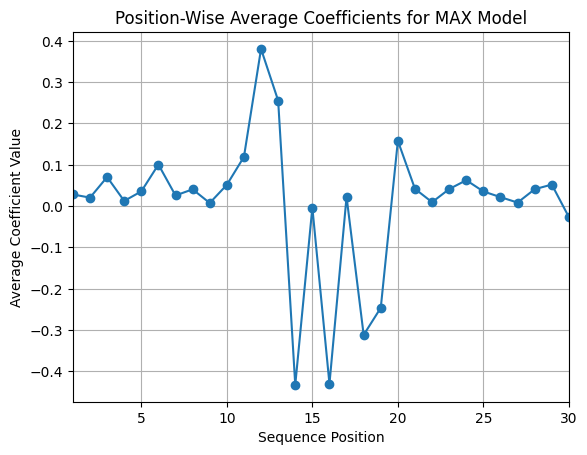

In [7]:
max_mean_coef = np.array([np.mean(values) for values in max_coef_values if values])
max_condensed_coefs = []
for i in range(0, len(max_mean_coef), 4):
    max_condensed_coefs.append(np.mean(max_mean_coef[i:i+4]))

plt.plot(range(1, len(max_condensed_coefs)+1), max_condensed_coefs, marker='o')
plt.xlabel('Sequence Position')
plt.ylabel('Average Coefficient Value')
plt.title('Position-Wise Average Coefficients for MAX Model')
plt.grid(True)
plt.xlim(1, 30)
plt.show()

Compare the plots generated for the two TFs and discuss your findings. [1pt]

**Overall, it appears that the logistic regression models trained for CTCF and MAX TFs reveal differences in important nucleotide bases for determination of binding affinity. For both TFs, we see a relatively low importance for the flanking regions as evidenced by the near-zero regression coefficients. However, we observe major fluctuations in coefficients near the center of the sequence for both TFs. There is greater variability within CTCF, as there are large and fluctuating coefficients between base pairs 5 and 25. Meanwhile, MAX demonstrates large and fluctuating coefficients between base pairs 10 and 20. CTCF appears to have stronger nucleotide signatures in the core of the sequence than MAX, as evidenced by the maximum coefficient magnitude of 0.6 compared to 0.4 for MAX. This may indicate that MAX TF may have a strong affinity for few, very specific sequences whereas CTCF may have an affinity for a wider range of sequences. All in all, our results show that nucleotides at specific sequence positions contribute more to our determination of binding affinity.**